In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


from xgboost import XGBRegressor, XGBClassifier

import optuna

/home/niklas/Documents/projects/kicktipp-betbot/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TRIALS = 400

In [3]:
df_matches = pd.read_csv("matches.csv")

## Baseline Models

In [4]:
class StaticEstimator(BaseEstimator):
    def __init__(self, result) -> None:
        super().__init__()
        self.result = result

    def fit(self, X, y):
        pass

    def predict(self, X):
        results = np.zeros((len(X), 2))
        results[:] = self.result
        return results

class RandomEstimator(BaseEstimator):
    
    def fit(self, X, y):
        df_result_counts = df_matches[["host_goals", "guest_goals"]].value_counts().reset_index()
        df_result_counts["p"] = df_result_counts["count"] / len(df_matches)
        self.df_result_counts = df_result_counts

    def predict(self, X):
        df_result_counts = self.df_result_counts
        result_indices = np.random.choice(df_result_counts.index, len(X), p=df_result_counts["p"].values)
        return df_result_counts.loc[result_indices, ["host_goals", "guest_goals"]].values

0:0: 187.69 +- 17.45
1:1: 223.38 +- 17.01
1:0: 354.46 +- 25.95
2:1: 359.69 +- 22.33
0:1: 245.77 +- 20.83
random: 266.00 +- 20.92


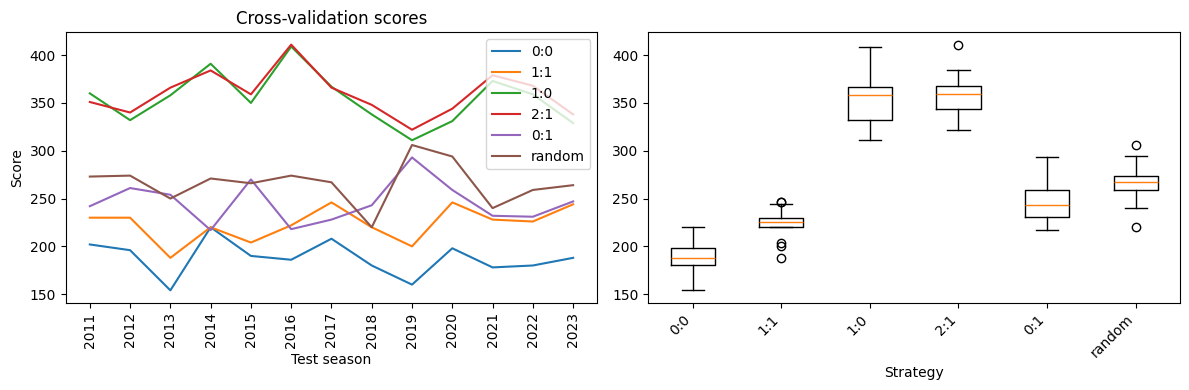

In [5]:
from utils import cross_val_splits, kicktipp_scoring


def evaluate_simple_models(scoring):
    splits = cross_val_splits(df_matches)
    labels = df_matches[["host_goals", "guest_goals"]].values
    static_results = [[0, 0], [1, 1], [1, 0], [2, 1], [0, 1]]
    static_result_scores = []
    for result in static_results:
        scores = cross_val_score(StaticEstimator(result), df_matches, labels, cv=splits, scoring=scoring)
        static_result_scores.append(scores)
    static_result_scores = np.array(static_result_scores)

    random_scores = cross_val_score(RandomEstimator(), df_matches, labels, cv=splits, scoring=scoring)

    all_scores = np.vstack((static_result_scores, random_scores))
    labels = [f"{res[0]}:{res[1]}" for res in static_results] + ["random"]
    for score, label in zip(all_scores, labels):
        print(f"{label}: {score.mean():.2f} +- {score.std():.2f}")

    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    split_test_seasons = [df_matches.iloc[split[1][0]]["season"] for  split in splits]
    axs[0].plot(all_scores.T, label=labels)
    axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
    axs[0].set_xlabel("Test season")
    axs[0].set_ylabel("Score")
    axs[0].legend()
    axs[0].set_title("Cross-validation scores")

    axs[1].boxplot(all_scores.T)
    axs[1].set_xlabel("Strategy")
    axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=45, ha="right")
    fig.tight_layout()

evaluate_simple_models(scoring=kicktipp_scoring)

# Matches with team context

In [6]:
df_full = pd.read_csv("matches_with_context.csv", index_col="id")
df_full = df_full.fillna(0)
df_full.tail()

,match_day,season,host_id,host_name,guest_id,guest_name,host_goals,guest_goals,host_last_season_draws,host_last_season_goal_diff,...,host_horizon_wins,host_horizon_draws,host_horizon_defeats,guest_horizon_points,guest_horizon_goals,guest_horizon_opponent_goals,guest_horizon_goal_diff,guest_horizon_wins,guest_horizon_draws,guest_horizon_defeats
id,,,,,,,,,,,,,,,,,,,,,
66932,34,2023,131,Wolfsburg,81,Mainz,1,3,10.0,9.0,...,14.000000,8.666667,11.333333,43.666667,47.666667,52.000000,-4.333333,11.666667,8.666667,13.666667
66933,34,2023,175,Hoffenheim,40,Bayern,4,2,6.0,-9.0,...,11.333333,7.666667,15.000000,75.333333,96.000000,39.666667,56.333333,23.000000,6.333333,4.666667
66934,34,2023,134,Bremen,129,Bochum,4,1,6.0,-13.0,...,8.500000,8.000000,17.500000,38.500000,39.000000,62.000000,-23.000000,11.000000,5.500000,17.500000
66935,34,2023,16,Stuttgart,87,Gladbach,4,0,12.0,-12.0,...,8.666667,11.000000,14.333333,45.666667,56.666667,57.333333,-0.666667,12.000000,9.666667,12.333333
66936,34,2023,199,Heidenheim,65,Köln,4,1,0.0,0.0,...,0.000000,0.000000,0.000000,42.333333,45.000000,54.333333,-9.333333,10.666667,10.333333,13.000000


In [7]:
X_all = df_full.drop(columns=["host_name", "guest_name", "host_goals", "guest_goals"])
y_all = df_full[["host_goals", "guest_goals"]].values
print(X_all.columns)

Index(['match_day', 'season', 'host_id', 'guest_id', 'host_last_season_draws',
       'host_last_season_goal_diff', 'host_last_season_goals',
       'host_last_season_defeats', 'host_last_season_matches',
       'host_last_season_opponent_goals', 'host_last_season_points',
       'host_last_season_wins', 'guest_last_season_draws',
       'guest_last_season_goal_diff', 'guest_last_season_goals',
       'guest_last_season_defeats', 'guest_last_season_matches',
       'guest_last_season_opponent_goals', 'guest_last_season_points',
       'guest_last_season_wins', 'host_horizon_points', 'host_horizon_goals',
       'host_horizon_opponent_goals', 'host_horizon_goal_diff',
       'host_horizon_wins', 'host_horizon_draws', 'host_horizon_defeats',
       'guest_horizon_points', 'guest_horizon_goals',
       'guest_horizon_opponent_goals', 'guest_horizon_goal_diff',
       'guest_horizon_wins', 'guest_horizon_draws', 'guest_horizon_defeats'],
      dtype='object')


In [8]:
class RoundingEstimator(BaseEstimator):
    def __init__(self, regressor, **kwargs) -> None:
        super().__init__()
        self.regressor = regressor
        self.regressor.set_params(**kwargs)
    
    def fit(self, X, y):
        self.regressor.fit(X, y)
    
    def predict(self, X):
        raw = self.regressor.predict(X)
        return np.round(raw)
    
    def get_params(self, deep = False):
        params = self.regressor.get_params(deep)
        params["regressor"] = self.regressor
        return params

    def set_params(self, **params):
        self.regressor.set_params(**params)
        return self

In [9]:
splits = cross_val_splits(X_all, start=3)
def objective(trial):
    rf_criterion = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])
    rf_max_depth = trial.suggest_int('max_depth', 2, 15)
    rf_n_estimators = trial.suggest_int('n_estimators', 50, 50)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    estimator = RoundingEstimator(RandomForestRegressor(
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        n_jobs=-1
    ))
    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

rf_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="rf", load_if_exists=True)
rf_study.optimize(objective, n_trials=TRIALS//4)
print(rf_study.best_value, rf_study.best_params)

[I 2024-09-02 19:02:37,099] A new study created in RDB with name: rf
[I 2024-09-02 19:02:57,565] Trial 0 finished with value: 324.54545454545456 and parameters: {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 50, 'min_samples_split': 53}. Best is trial 0 with value: 324.54545454545456.
[I 2024-09-02 19:02:58,541] Trial 1 finished with value: 381.3636363636364 and parameters: {'criterion': 'squared_error', 'max_depth': 3, 'n_estimators': 50, 'min_samples_split': 39}. Best is trial 1 with value: 381.3636363636364.
[I 2024-09-02 19:03:48,646] Trial 2 finished with value: 340.90909090909093 and parameters: {'criterion': 'absolute_error', 'max_depth': 8, 'n_estimators': 50, 'min_samples_split': 52}. Best is trial 1 with value: 381.3636363636364.
[I 2024-09-02 19:03:49,539] Trial 3 finished with value: 355.09090909090907 and parameters: {'criterion': 'friedman_mse', 'max_depth': 2, 'n_estimators': 50, 'min_samples_split': 82}. Best is trial 1 with value: 381.3636363636364.
[I

391.90909090909093 {'criterion': 'squared_error', 'max_depth': 2, 'n_estimators': 50, 'min_samples_split': 43}


In [10]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 50, 50)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    if algo == "xgb":
        estimator = RoundingEstimator(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        ))
    elif algo == "lgbm":
        estimator = RoundingEstimator(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["rmse", "mae", "poisson", "mape"]),
        )))

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb", load_if_exists=True)
gb_study.optimize(objective, n_trials=TRIALS)
print(gb_study.best_value, gb_study.best_params)

[I 2024-09-02 19:09:13,334] A new study created in RDB with name: gb
[I 2024-09-02 19:09:13,867] Trial 0 finished with value: 334.54545454545456 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 13, 'lambda': 1.553775459619545, 'alpha': 1.7433562225699213, 'learning_rate': 0.27903048720275153, 'num_leaves': 25, 'min_child_weight': 9.37954392466585, 'objective-lgbm': 'rmse'}. Best is trial 0 with value: 334.54545454545456.
[I 2024-09-02 19:09:14,356] Trial 1 finished with value: 328.1818181818182 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 4, 'lambda': 1.0478832568915517, 'alpha': 0.5836538012349111, 'learning_rate': 0.19534756065880732, 'num_leaves': 17, 'min_child_weight': 3.642880220571378, 'objective-xgb': 'reg:squaredlogerror'}. Best is trial 0 with value: 334.54545454545456.
[I 2024-09-02 19:09:14,763] Trial 2 finished with value: 366.09090909090907 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 8, 'lambda': 1.338872564990294

388.3636363636364 {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 4, 'lambda': 0.0025283963832197845, 'alpha': 0.5910020097633829, 'learning_rate': 0.03513869698407484, 'num_leaves': 4, 'min_child_weight': 10.744521650894574, 'objective-lgbm': 'poisson'}


In [11]:
def build_gb_model(study, rounder=RoundingEstimator):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda=params["lambda"]
    reg_alpha=params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves=params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    if algo == "xgb":
        estimator = rounder(XGBRegressor(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-xgb"],
        ))
    elif algo == "lgbm":
        estimator = rounder(MultiOutputRegressor(LGBMRegressor(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-lgbm"],
        )))
    return estimator
    

Scoring StaticEstimator(result=[2, 1])
Scoring RoundingEstimator(bootstrap=True, ccp_alpha=0.0, criterion='squared_error',
                  max_depth=2, max_features=1.0, max_leaf_nodes=None,
                  max_samples=None, min_impurity_decrease=0.0,
                  min_samples_leaf=1, min_samples_split=43,
                  min_weight_fraction_leaf=0.0, monotonic_cst=None,
                  n_estimators=50, n_jobs=None, oob_score=False,
                  random_state=None,
                  regressor=RandomForestRegressor(max_depth=2,
                                                  min_samples_split=43,
                                                  n_estimators=50),
                  verbose=0, warm_start=False)
Scoring RoundingEstimator(estimator=LGBMRegressor(learning_rate=0.03513869698407484,
                                          max_depth=4,
                                          min_child_weight=10.744521650894574,
                                          n_e

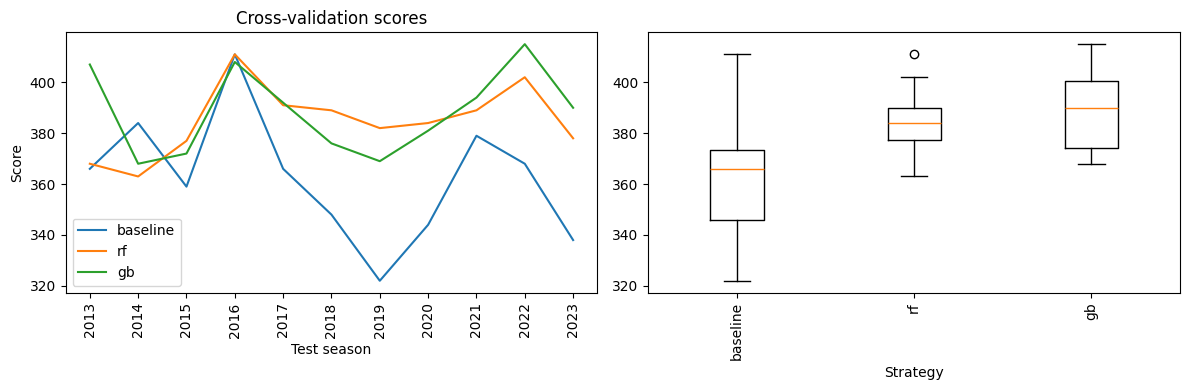

In [12]:
from sklearn.linear_model import BayesianRidge

models = {
    "baseline": StaticEstimator([2, 1]),
    "rf": RoundingEstimator(RandomForestRegressor(
        criterion=rf_study.best_params['criterion'], 
        max_depth=rf_study.best_params['max_depth'], 
        n_estimators=rf_study.best_params['n_estimators'], 
        min_samples_split=rf_study.best_params['min_samples_split']
    )),
    "gb": build_gb_model(gb_study)
}

all_scores = []

for model in models.values():
    print(f"Scoring {model}")
    scores = cross_val_score(model, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    all_scores.append(scores)

all_scores = np.array(all_scores)
labels = models.keys()

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
split_test_seasons = [df_matches.iloc[split[1][0]]["season"] for  split in splits]
axs[0].plot(all_scores.T, label=labels)
axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
axs[0].set_xlabel("Test season")
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].set_title("Cross-validation scores")

axs[1].boxplot(all_scores.T)
axs[1].set_xlabel("Strategy")
axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=90, ha="center")
fig.tight_layout()
!


In [13]:
model = build_gb_model(gb_study)
train_idx, test_idx = splits[-2]
X_train, X_test = X_all.iloc[train_idx], X_all.iloc[test_idx]
y_train, y_test = y_all[train_idx], y_all[test_idx]
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred_raw = model.regressor.predict(X_train)

df_full_train = df_full.iloc[train_idx].copy()
df_full_train["team1Goals_pred"] = y_train_pred[:, 0]
df_full_train["team2Goals_pred"] = y_train_pred[:, 1]
df_full_train["team1Goals_pred_raw"] = y_train_pred_raw[:, 0]
df_full_train["team2Goals_pred_raw"] = y_train_pred_raw[:, 1]
df_full_train[["season", "match_day", "host_name", "guest_name", "host_goals", "guest_goals", "team1Goals_pred", "team2Goals_pred"]]

,season,match_day,host_name,guest_name,host_goals,guest_goals,team1Goals_pred,team2Goals_pred
id,,,,,,,,
9998,2010,1,Bayern,Wolfsburg,2,1,2.0,1.0
10002,2010,1,Hoffenheim,Bremen,4,1,2.0,1.0
10003,2010,1,Gladbach,Nürnberg,1,1,2.0,1.0
10004,2010,1,Köln,Kaiserslautern,1,3,2.0,1.0
10005,2010,1,Freiburg,St. Pauli,1,3,2.0,1.0
...,...,...,...,...,...,...,...,...
61146,2021,34,Gladbach,Hoffenheim,5,1,2.0,1.0
61147,2021,34,Mainz,Frankfurt,2,2,1.0,1.0
61148,2021,34,Stuttgart,Köln,2,1,2.0,1.0


In [14]:
df_full_train[["team1Goals_pred", "team2Goals_pred"]].value_counts()

team1Goals_pred  team2Goals_pred
2.0              1.0                2931
1.0              2.0                 511
                 1.0                 197
2.0              2.0                  33
Name: count, dtype: int64

# Classification

In [15]:
from sklearn.preprocessing import LabelEncoder


class ClassifierEstimator(BaseEstimator):
    def __init__(self, classifier, max_goals=3, **kwargs) -> None:
        super().__init__()
        self.classifier = classifier
        self.classifier.set_params(**kwargs)
        self.target_encoder = LabelEncoder()
        self.max_goals = max_goals

    @staticmethod
    def clip_results(results: np.ndarray, max_goals=3):
        results = results.copy()
        match_goals = results.sum(axis=1)
        for i, res in enumerate(results):
            while match_goals[i] > max_goals:
                results[i, 0] = np.max((0, results[i, 0] - 1))
                results[i, 1] = np.max((0, results[i, 1] - 1))
                match_goals[i] = results[i, 0] + results[i, 1]
        return results.astype(results.dtype)
    
    def fit(self, X, y):
        y = ClassifierEstimator.clip_results(y, self.max_goals)
        results = [f"{a[0]}:{a[1]}" for a in y]
        self.target_encoder.fit(results)
        results_encoded = self.target_encoder.transform(results)
        self.classifier.fit(X, results_encoded)
    
    def predict(self, X):
        raw = self.classifier.predict(X)
        results = self.target_encoder.inverse_transform(raw)
        y = [[int(a.split(":")[0]), int(a.split(":")[1])] for a in results]
        return np.array(y)
    
    def get_params(self, deep = False):
        params = self.classifier.get_params(deep)
        params["classifier"] = self.classifier
        return params

    def set_params(self, **params):
        self.classifier.set_params(**params)
        return self

In [16]:
def objective(trial):
    rf_criterion = trial.suggest_categorical("criterion", ["gini", "log_loss", "entropy"])
    rf_max_depth = trial.suggest_int('max_depth', 2, 15)
    rf_n_estimators = trial.suggest_int('n_estimators', 50, 50)
    rf_min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    max_goals = trial.suggest_int('max_goals', 1, 5)
    estimator = ClassifierEstimator(RandomForestClassifier(
        n_estimators=rf_n_estimators, 
        criterion=rf_criterion,
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        n_jobs=-1
    ), max_goals=max_goals)
    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

rf_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="rf-classifier", load_if_exists=True)
rf_study.optimize(objective, n_trials=TRIALS//4)
print(rf_study.best_value, rf_study.best_params)

[I 2024-09-02 19:11:21,103] A new study created in RDB with name: rf-classifier
[I 2024-09-02 19:11:22,178] Trial 0 finished with value: 317.90909090909093 and parameters: {'criterion': 'log_loss', 'max_depth': 10, 'n_estimators': 50, 'min_samples_split': 35, 'max_goals': 1}. Best is trial 0 with value: 317.90909090909093.
[I 2024-09-02 19:11:23,232] Trial 1 finished with value: 317.54545454545456 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 50, 'min_samples_split': 11, 'max_goals': 1}. Best is trial 0 with value: 317.90909090909093.
[I 2024-09-02 19:11:24,322] Trial 2 finished with value: 324.0 and parameters: {'criterion': 'log_loss', 'max_depth': 14, 'n_estimators': 50, 'min_samples_split': 17, 'max_goals': 4}. Best is trial 2 with value: 324.0.
[I 2024-09-02 19:11:25,229] Trial 3 finished with value: 301.3636363636364 and parameters: {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50, 'min_samples_split': 7, 'max_goals': 1}. Best is trial 2 with va

336.8181818181818 {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 50, 'min_samples_split': 16, 'max_goals': 3}


In [17]:

from lightgbm import LGBMClassifier

def objective(trial):
    algo = trial.suggest_categorical("algo", ["xgb", "lgbm"])
    n_estimators = trial.suggest_int("n_estimators", 50, 50)
    max_depth = trial.suggest_int("max_depth", 2, 15)
    reg_lambda=trial.suggest_float("lambda", 0.0, 2.0)
    reg_alpha=trial.suggest_float("alpha", 0.0, 2.0)
    learning_rate = trial.suggest_float("learning_rate", 0.0, 0.5)
    num_leaves=trial.suggest_int("num_leaves", 2, 31)
    min_child_weight = trial.suggest_float("min_child_weight", 0, 15)
    max_goals = trial.suggest_int('max_goals', 1, 5)
    if algo == "xgb":
        estimator = ClassifierEstimator(XGBClassifier(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-xgb", ["multi:softmax"]),
        ), max_goals=max_goals)
    elif algo == "lgbm":
        estimator = ClassifierEstimator(LGBMClassifier(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=trial.suggest_categorical("objective-lgbm", ["multiclass"]),
        ), max_goals=max_goals)

    scores = cross_val_score(estimator, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    return np.mean(scores)

gb_study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name="gb-classifier", load_if_exists=True)
gb_study.optimize(objective, n_trials=TRIALS//2)
print(gb_study.best_value, gb_study.best_params)

[I 2024-09-02 19:13:08,876] A new study created in RDB with name: gb-classifier
[I 2024-09-02 19:13:09,453] Trial 0 finished with value: 332.54545454545456 and parameters: {'algo': 'lgbm', 'n_estimators': 50, 'max_depth': 8, 'lambda': 0.21213742419205217, 'alpha': 0.20627775628236544, 'learning_rate': 0.27899233908304283, 'num_leaves': 3, 'min_child_weight': 3.1073725860555172, 'max_goals': 5, 'objective-lgbm': 'multiclass'}. Best is trial 0 with value: 332.54545454545456.
[I 2024-09-02 19:13:10,446] Trial 1 finished with value: 337.6363636363636 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 2, 'lambda': 0.6858238290445666, 'alpha': 0.5972966237921382, 'learning_rate': 0.31714511710523646, 'num_leaves': 11, 'min_child_weight': 13.380655081385438, 'max_goals': 3, 'objective-xgb': 'multi:softmax'}. Best is trial 1 with value: 337.6363636363636.
[I 2024-09-02 19:13:12,279] Trial 2 finished with value: 333.0 and parameters: {'algo': 'xgb', 'n_estimators': 50, 'max_depth'

353.09090909090907 {'algo': 'xgb', 'n_estimators': 50, 'max_depth': 5, 'lambda': 1.9626771325969885, 'alpha': 1.8140889726025053, 'learning_rate': 0.15168475979798546, 'num_leaves': 14, 'min_child_weight': 13.581167963001127, 'max_goals': 3, 'objective-xgb': 'multi:softmax'}


In [18]:
def build_gb_model_classifier(study):
    params = study.best_params
    algo = params["algo"]
    n_estimators = params["n_estimators"]
    max_depth = params["max_depth"]
    reg_lambda=params["lambda"]
    reg_alpha=params["alpha"]
    learning_rate = params["learning_rate"]
    num_leaves=params["num_leaves"]
    min_child_weight = params["min_child_weight"]
    max_goals = params["max_goals"]
    if algo == "xgb":
        estimator = ClassifierEstimator(XGBClassifier(
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            max_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-xgb"],
        ), max_goals=max_goals)
    elif algo == "lgbm":
        estimator = ClassifierEstimator(LGBMClassifier(
            verbose=-1,
            n_jobs=-1,
            n_estimators = n_estimators,
            max_depth = max_depth,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_weight=min_child_weight,
            objective=params["objective-lgbm"],
        ), max_goals=max_goals)
    return estimator
    

Scoring StaticEstimator(result=[2, 1])
Scoring ClassifierEstimator(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                    classifier=RandomForestClassifier(max_depth=15,
                                                      min_samples_split=16,
                                                      n_estimators=50),
                    criterion='gini', max_depth=15, max_features='sqrt',
                    max_leaf_nodes=None, max_samples=None,
                    min_impurity_decrease=0.0, min_samples_leaf=1,
                    min_samples_split=16, min_weight_fraction_leaf=0.0,
                    monotonic_cst=None, n_estimators=50, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)
Scoring ClassifierEstimator(base_score=None, booster=None, callbacks=None,
                    classifier=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
         

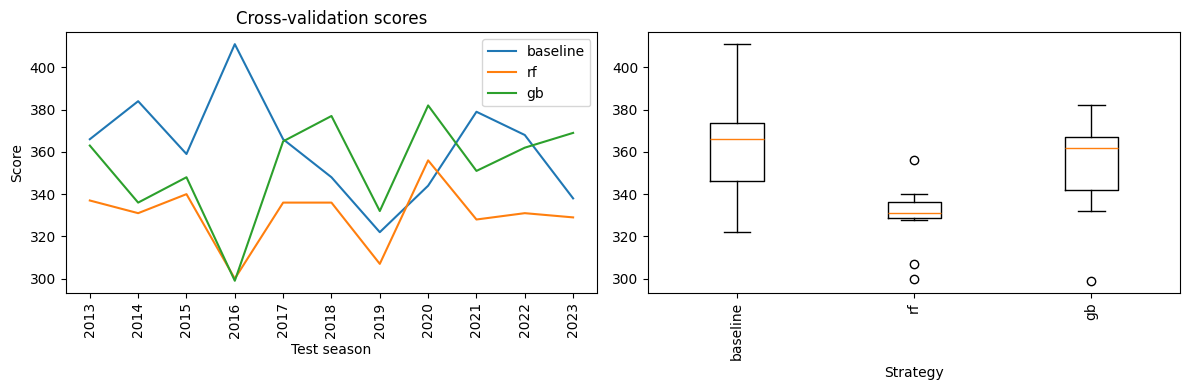

In [19]:
models = {
    "baseline": StaticEstimator([2, 1]),
    "rf": ClassifierEstimator(RandomForestClassifier(
        criterion=rf_study.best_params['criterion'], 
        max_depth=rf_study.best_params['max_depth'], 
        n_estimators=rf_study.best_params['n_estimators'], 
        min_samples_split=rf_study.best_params['min_samples_split']
    ), max_goals=rf_study.best_params["max_goals"]),
    "gb": build_gb_model_classifier(gb_study)
}

all_scores = []

for model in models.values():
    print(f"Scoring {model}")
    scores = cross_val_score(model, X_all, y_all, cv=splits, verbose=1, scoring=kicktipp_scoring)
    all_scores.append(scores)

all_scores = np.array(all_scores)
labels = models.keys()

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
split_test_seasons = [df_matches.iloc[split[1][0]]["season"] for  split in splits]
axs[0].plot(all_scores.T, label=labels)
axs[0].set_xticks(range(len(split_test_seasons)), split_test_seasons, rotation=90, ha='center')
axs[0].set_xlabel("Test season")
axs[0].set_ylabel("Score")
axs[0].legend()
axs[0].set_title("Cross-validation scores")

axs[1].boxplot(all_scores.T)
axs[1].set_xlabel("Strategy")
axs[1].set_xticks(range(1, len(labels) +1), labels, rotation=90, ha="center")
fig.tight_layout()
!